### Regions Display

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os
from time import time

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities_NOMXNET import *

/Users/kuiqian/Github/MouseBrainAtlas_dev/src//utilities/utilities2015.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/kuiqian/Github/venv/mousebrainatlas_virtualenv/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/kuiqian/Github/venv/mousebrainatlas_virtualenv/lib/python2.7/site-packages/

Setting environment for an unknown machine. Global root paths must be set as env variables.
{'MD589': 0.46}
Loaded data from saved metadata_cache for MD589


No vtk
No mcubes
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD585 anchor: ini file /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/operation_configs/from_none_to_aligned.ini does not exist.
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD585 section_limits: ini file /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/operation_configs/from_none_to_aligned.ini does not exist.
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD585 cropbox: ini file /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/operation_configs/from_none_to_aligned.ini does not exist.
Failed to cache MD585 valid_sections/filenames: MD585
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to

### Variables definition

In [2]:
win_id = 0
stack = 'MD589'

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

# 1: {'patch_size': 224, 'spacing': 56}
images_root = ROOT_DIR+'/CSHL_data_processed/'+stack+'/'+stack+'_prep2_thumbnail/'
raw_images_root = ROOT_DIR+'/CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'

image_fn_list = ! ls $images_root
raw_image_fn_list = ! ls $raw_images_root

filename_to_section, section_to_filename = DataManager.load_sorted_filenames( stack )

In [3]:
windowing_settings

{0: {'patch_size': 34, 'spacing': 34},
 1: {'patch_size': 224, 'spacing': 56},
 2: {'comment': 'larger margin', 'patch_size': 224, 'spacing': 56},
 3: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 32},
 4: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 128},
 5: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 64},
 6: {'comment': 'twice as large patch', 'patch_size': 448, 'spacing': 64},
 7: {'comment': 'specify size/spacing in terms of microns rather than pixels',
  'patch_size_um': 103.04,
  'spacing_um': 30},
 8: {'comment': 'larger patch', 'patch_size_um': 206.08, 'spacing_um': 30},
 9: {'comment': 'larger patch', 'patch_size_um': 412.16, 'spacing_um': 30},
 10: {'comment': 'larger patch', 'patch_size_um': 824.32, 'spacing_um': 30},
 11: {'comment': 'larger patch', 'patch_size_um': 51.52, 'spacing_um': 30},
 12: {'comment': 'larger patch', 'patch_size_um': 25.76, 'spacing_um': 30}}

### Identify regions based on human annotation
--script identify_patch_class_based_on_labeling_v3_human_annotations.py

In [4]:
fp, latest_timestamp = DataManager.get_annotation_filepath(stack, by_human=True, suffix='contours', \
            timestamp='latest', return_timestamp=True, annotation_rootdir=ANNOTATION_ROOTDIR, download_s3=False)
grid_index_class_lookup_fp = DataManager.get_annotation_to_grid_indices_lookup_filepath(stack=stack, \
                                        win_id=win_id, by_human=True, timestamp=latest_timestamp)
t0 = time.time()
if not os.path.exists(grid_index_class_lookup_fp):
    ! python identify_patch_class_based_on_labeling_v3_human_annotations.py MD589 $win_id
else:
    print('ALREADY IDENTIFY PATCHES')
print(time.time()-t0)
print(grid_index_class_lookup_fp)
grid_index_class_lookup = load_hdf_v2(grid_index_class_lookup_fp)

latest timestamp:  05312018031718
ALREADY IDENTIFY PATCHES
0.00549697875977
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_labelings_v3/MD589/MD589_annotation_win0_05312018031718_grid_indices_lookup.hdf


In [5]:
# Convert to x, y locations using 'all_locs'
all_locs = grid_parameters_to_sample_locations(win_id=win_id, stack=stack)

### Positive region examples display

In [6]:
all_patch_locations = {}

for structure in all_structures:    
    valid_sections = []
    try:
        possibly_valid_sections = grid_index_class_lookup[structure].keys()
    except Exception as e:
        print(e)
        print('SKIPPING: '+structure)
        continue
        
    all_patch_locations[structure] = {}

    # Make a list of all sections where patches actually exist
    for section in possibly_valid_sections:
        # If this table entry is a numpy array, then it is filled with data. Otherwise (float) it is 'nan'
        if isinstance(grid_index_class_lookup[structure][section], np.ndarray):
            valid_sections.append( section )
            
    for section in valid_sections:
        valid_patch_indices = grid_index_class_lookup[structure][ section ]
        patch_coors =  all_locs[ valid_patch_indices ]#.tolist()
        all_patch_locations[structure][int(section)] = patch_coors

349
Number of Positive Patches: 1154
(7599, 8959, 7259, 8585)
uint8
(1154, 1154)
uint8
(1361, 1395)


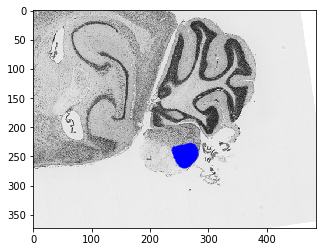

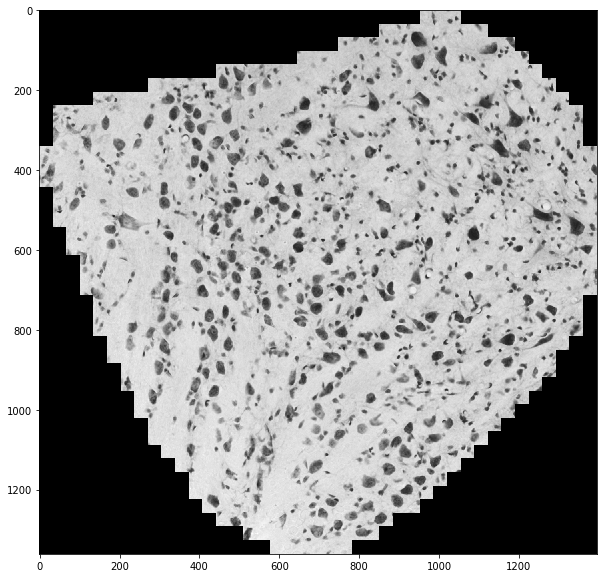

In [13]:
x_pts_str = []
y_pts_str = []
x_raw = []
y_raw = []
offset = 34
structure = 'VCP'
section = all_patch_locations[structure].keys()[20]
print(section)
valid_patch_indices = grid_index_class_lookup[structure][ section ]
print 'Number of Positive Patches:',len(valid_patch_indices)

[left, right, up, down] = [int(min(all_patch_locations[structure][section][:,0])), 
                           int(max(all_patch_locations[structure][section][:,0])),
                           int(min(all_patch_locations[structure][section][:,1])), 
                           int(max(all_patch_locations[structure][section][:,1]))]

for x, y in all_locs[valid_patch_indices]:
    x_raw.append( (int(x-left)) )
    y_raw.append( (int(y-up)) )
    x_pts_str.append( (float(x)/32))
    y_pts_str.append( (float(y)/32))
    
img = cv2.imread( images_root+section_to_filename[section]+'_prep2_thumbnail.tif' , 2)
#plt.figure( figsize=(50,50) )
plt.imshow( img, cmap='gray')
plt.scatter(x_pts_str, y_pts_str, s=1, c='blue', alpha=.5)

print(left, right, up, down)
img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif' , 2)
print(img.dtype)
mask = np.zeros((down-up+1+offset, right-left+1+offset))
print(len(x_raw),len(y_raw))
for i in range(len(all_locs[valid_patch_indices])):
    mask[y_raw[i]:y_raw[i]+offset,x_raw[i]:x_raw[i]+offset]=1
mask=mask.astype(np.uint8)
print(mask.dtype)
patch = img[up:down+1+offset,left:right+1+offset]*mask#[0:down-up+1,0:right-left+1]
print(patch.shape)
plt.figure( figsize=(10,10) )
plt.imshow( patch, cmap='gray')
#plt.imshow(mask, cmap='gray')

#plt.scatter(x_raw, y_raw, s=1, c='blue', alpha=.5)

### Positive region examples display

In [11]:
for structure in all_structures: 
    structure=structure+'_surround_200um_noclass'
    valid_sections = []
    try:
        possibly_valid_sections = grid_index_class_lookup[structure].keys()
    except Exception as e:
        print(e)
        print('SKIPPING: '+structure)
        continue
        
    all_patch_locations[structure] = {}

    # Make a list of all sections where patches actually exist
    for section in possibly_valid_sections:
        # If this table entry is a numpy array, then it is filled with data. Otherwise (float) it is 'nan'
        if isinstance(grid_index_class_lookup[structure][section], np.ndarray):
            valid_sections.append( section )
            
    for section in valid_sections:
        valid_patch_indices = grid_index_class_lookup[structure][ section ]
        patch_coors =  all_locs[ valid_patch_indices ]#.tolist()
        all_patch_locations[structure][int(section)] = patch_coors

Number of Negative Patches: 1285
(7191, 9401, 6919, 8993)
uint8
(1285, 1285)
uint8
(2109, 2245)


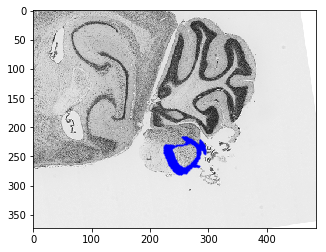

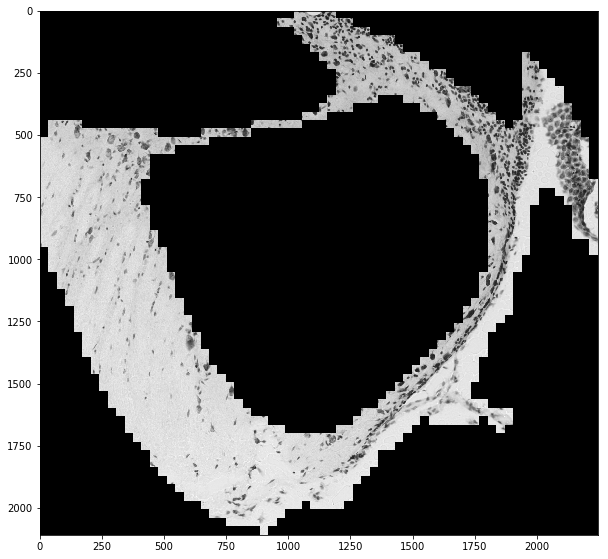

In [14]:
x_pts_str = []
y_pts_str = []
x_raw = []
y_raw = []
offset = 34
structure = 'VCP'+'_surround_200um_noclass'
section = all_patch_locations[structure].keys()[20]
valid_patch_indices = grid_index_class_lookup[structure][ section ]
print 'Number of Negative Patches:',len(valid_patch_indices)

[left, right, up, down] = [int(min(all_locs[valid_patch_indices][:,0])), int(max(all_locs[valid_patch_indices][:,0])), \
                           int(min(all_locs[valid_patch_indices][:,1])), int(max(all_locs[valid_patch_indices][:,1]))]

for x, y in all_locs[valid_patch_indices]:
    x_raw.append( (int(x-left)) )
    y_raw.append( (int(y-up)) )
    x_pts_str.append( (float(x)/32) )
    y_pts_str.append( (float(y)/32) )
    
img = cv2.imread( images_root+section_to_filename[section]+'_prep2_thumbnail.tif' , 2)
#plt.figure( figsize=(50,50) )
plt.imshow( img, cmap='gray')
plt.scatter(x_pts_str, y_pts_str, s=1, c='blue', alpha=.5)

print(left, right, up, down)
img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif' , 2)
print(img.dtype)
mask = np.zeros((down-up+1+offset, right-left+1+offset))
print(len(x_raw),len(y_raw))
for i in range(len(all_locs[valid_patch_indices])):
    mask[y_raw[i]:y_raw[i]+offset,x_raw[i]:x_raw[i]+offset]=1
mask=mask.astype(np.uint8)
print(mask.dtype)
patch = img[up:down+1+offset,left:right+1+offset]*mask#[0:down-up+1,0:right-left+1]
print(patch.shape)
plt.figure( figsize=(10,10) )
plt.imshow( patch, cmap='gray')
#plt.imshow(mask, cmap='gray')

#plt.scatter(x_raw, y_raw, s=1, c='blue', alpha=.5)

### Results of the form window

In [16]:
win_id = 1
fp, latest_timestamp = DataManager.get_annotation_filepath(stack, by_human=True, suffix='contours', \
            timestamp='latest', return_timestamp=True, annotation_rootdir=ANNOTATION_ROOTDIR, download_s3=False)
grid_index_class_lookup_fp = DataManager.get_annotation_to_grid_indices_lookup_filepath(stack=stack, \
                                        win_id=win_id, by_human=True, timestamp=latest_timestamp)
t0 = time.time()
if not os.path.exists(grid_index_class_lookup_fp):
    ! python identify_patch_class_based_on_labeling_v3_human_annotations.py MD589 $win_id
else:
    print('ALREADY IDENTIFY PATCHES')
print(time.time()-t0)
print(grid_index_class_lookup_fp)
grid_index_class_lookup = load_hdf_v2(grid_index_class_lookup_fp)
all_locs = grid_parameters_to_sample_locations(win_id=win_id, stack=stack)

latest timestamp:  05312018031718
ALREADY IDENTIFY PATCHES
0.000247955322266
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_labelings_v3/MD589/MD589_annotation_win1_05312018031718_grid_indices_lookup.hdf


In [17]:
all_patch_locations = {}

for structure in all_structures:    
    valid_sections = []
    try:
        possibly_valid_sections = grid_index_class_lookup[structure].keys()
    except Exception as e:
        print(e)
        print('SKIPPING: '+structure)
        continue
        
    all_patch_locations[structure] = {}

    # Make a list of all sections where patches actually exist
    for section in possibly_valid_sections:
        # If this table entry is a numpy array, then it is filled with data. Otherwise (float) it is 'nan'
        if isinstance(grid_index_class_lookup[structure][section], np.ndarray):
            valid_sections.append( section )
            
    for section in valid_sections:
        valid_patch_indices = grid_index_class_lookup[structure][ section ]
        patch_coors =  all_locs[ valid_patch_indices ]#.tolist()
        all_patch_locations[structure][int(section)] = patch_coors

In [18]:
for structure in all_structures: 
    structure=structure+'_surround_200um_noclass'
    valid_sections = []
    try:
        possibly_valid_sections = grid_index_class_lookup[structure].keys()
    except Exception as e:
        print(e)
        print('SKIPPING: '+structure)
        continue
        
    all_patch_locations[structure] = {}

    # Make a list of all sections where patches actually exist
    for section in possibly_valid_sections:
        # If this table entry is a numpy array, then it is filled with data. Otherwise (float) it is 'nan'
        if isinstance(grid_index_class_lookup[structure][section], np.ndarray):
            valid_sections.append( section )
            
    for section in valid_sections:
        valid_patch_indices = grid_index_class_lookup[structure][ section ]
        patch_coors =  all_locs[ valid_patch_indices ]#.tolist()
        all_patch_locations[structure][int(section)] = patch_coors

349
Number of Positive Patches: 372
(7672, 8904, 7336, 8512)
uint8
(372, 372)
uint8
(1401, 1457)


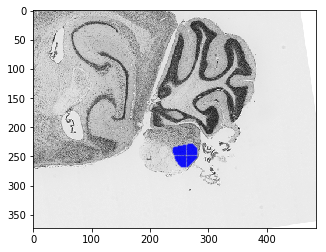

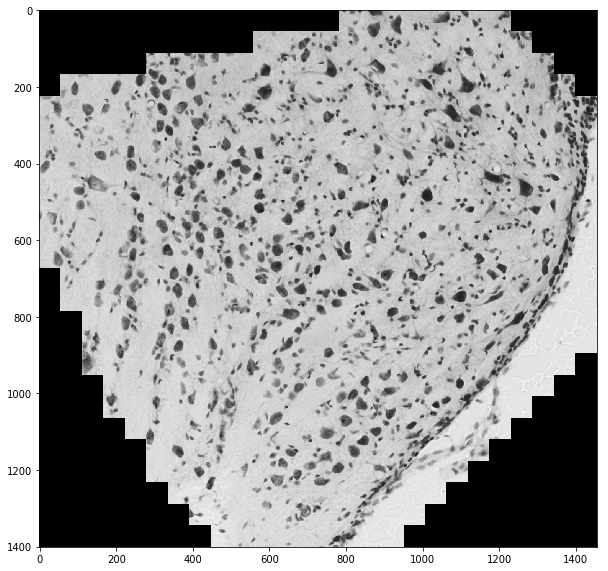

In [19]:
x_pts_str = []
y_pts_str = []
x_raw = []
y_raw = []
offset = 224
structure = 'VCP'
section = all_patch_locations[structure].keys()[20]
print(section)
valid_patch_indices = grid_index_class_lookup[structure][ section ]
print 'Number of Positive Patches:',len(valid_patch_indices)

[left, right, up, down] = [int(min(all_patch_locations[structure][section][:,0])), 
                           int(max(all_patch_locations[structure][section][:,0])),
                           int(min(all_patch_locations[structure][section][:,1])), 
                           int(max(all_patch_locations[structure][section][:,1]))]

for x, y in all_locs[valid_patch_indices]:
    x_raw.append( (int(x-left)) )
    y_raw.append( (int(y-up)) )
    x_pts_str.append( (float(x)/32))
    y_pts_str.append( (float(y)/32))
    
img = cv2.imread( images_root+section_to_filename[section]+'_prep2_thumbnail.tif' , 2)
#plt.figure( figsize=(50,50) )
plt.imshow( img, cmap='gray')
plt.scatter(x_pts_str, y_pts_str, s=1, c='blue', alpha=.5)

print(left, right, up, down)
img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif' , 2)
print(img.dtype)
mask = np.zeros((down-up+1+offset, right-left+1+offset))
print(len(x_raw),len(y_raw))
for i in range(len(all_locs[valid_patch_indices])):
    mask[y_raw[i]:y_raw[i]+offset,x_raw[i]:x_raw[i]+offset]=1
mask=mask.astype(np.uint8)
print(mask.dtype)
patch = img[up:down+1+offset,left:right+1+offset]*mask#[0:down-up+1,0:right-left+1]
print(patch.shape)
plt.figure( figsize=(10,10) )
plt.imshow( patch, cmap='gray')
#plt.imshow(mask, cmap='gray')

#plt.scatter(x_raw, y_raw, s=1, c='blue', alpha=.5)

Number of Negative Patches: 515
(7224, 9352, 6944, 8960)
uint8
(515, 515)
uint8
(2241, 2353)


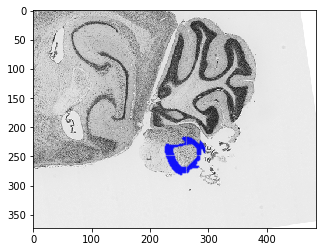

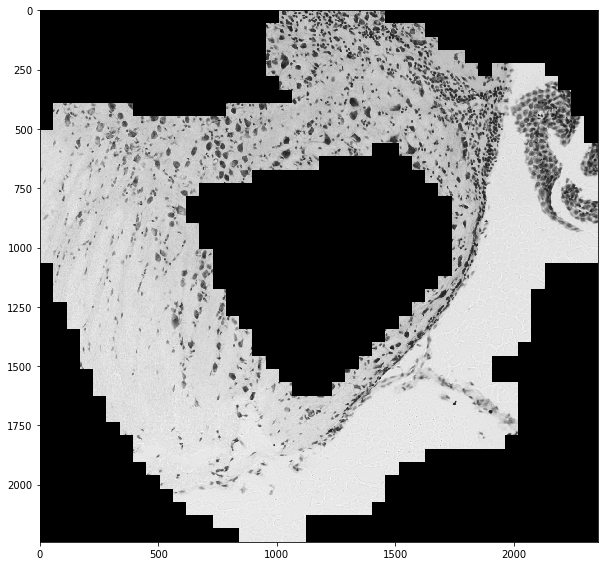

In [20]:
x_pts_str = []
y_pts_str = []
x_raw = []
y_raw = []
structure = 'VCP'+'_surround_200um_noclass'
section = all_patch_locations[structure].keys()[20]
valid_patch_indices = grid_index_class_lookup[structure][ section ]
print 'Number of Negative Patches:',len(valid_patch_indices)

[left, right, up, down] = [int(min(all_locs[valid_patch_indices][:,0])), int(max(all_locs[valid_patch_indices][:,0])), \
                           int(min(all_locs[valid_patch_indices][:,1])), int(max(all_locs[valid_patch_indices][:,1]))]

for x, y in all_locs[valid_patch_indices]:
    x_raw.append( (int(x-left)) )
    y_raw.append( (int(y-up)) )
    x_pts_str.append( (float(x)/32) )
    y_pts_str.append( (float(y)/32) )
    
img = cv2.imread( images_root+section_to_filename[section]+'_prep2_thumbnail.tif' , 2)
#plt.figure( figsize=(50,50) )
plt.imshow( img, cmap='gray')
plt.scatter(x_pts_str, y_pts_str, s=1, c='blue', alpha=.5)

print(left, right, up, down)
img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif' , 2)
print(img.dtype)
mask = np.zeros((down-up+1+offset, right-left+1+offset))
print(len(x_raw),len(y_raw))
for i in range(len(all_locs[valid_patch_indices])):
    mask[y_raw[i]:y_raw[i]+offset,x_raw[i]:x_raw[i]+offset]=1
mask=mask.astype(np.uint8)
print(mask.dtype)
patch = img[up:down+1+offset,left:right+1+offset]*mask#[0:down-up+1,0:right-left+1]
print(patch.shape)
plt.figure( figsize=(10,10) )
plt.imshow( patch, cmap='gray')
#plt.imshow(mask, cmap='gray')

#plt.scatter(x_raw, y_raw, s=1, c='blue', alpha=.5)

In [ ]:
cv2.dilate()